In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv("Task 3 and 4_Loan_Data.csv")
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


## Pie Chart of Proportions

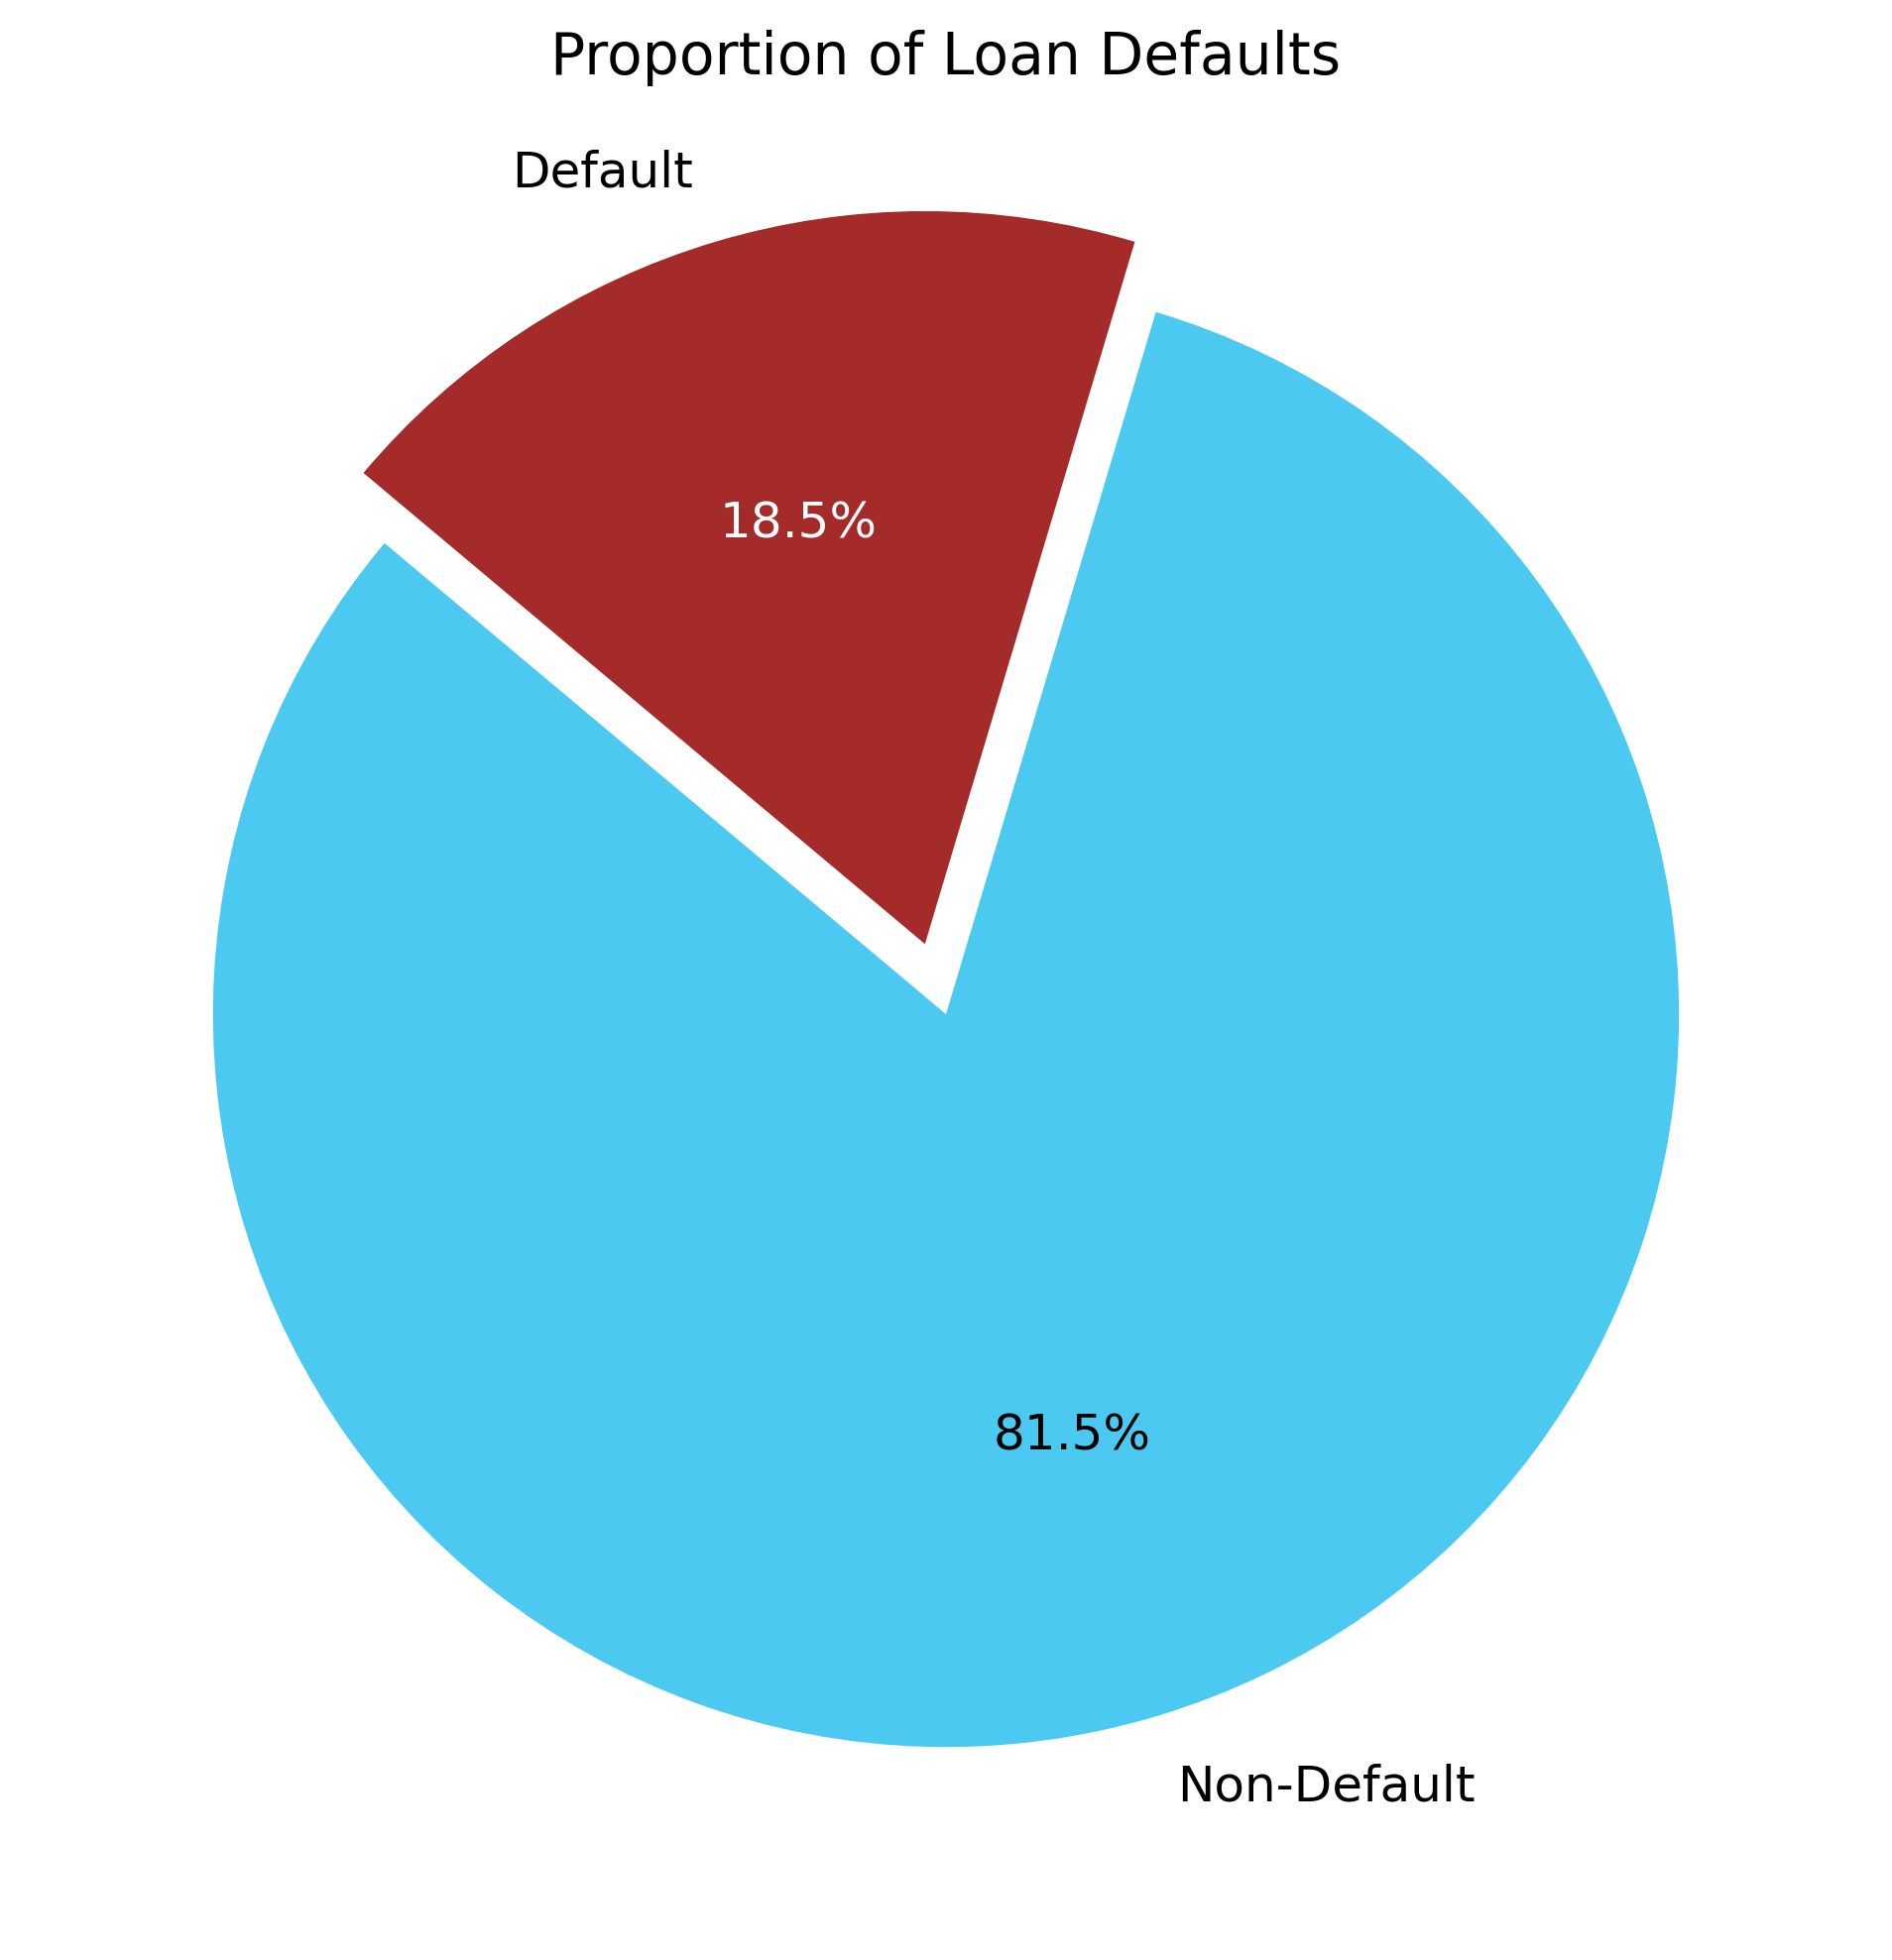

default
0    8149
1    1851
Name: count, dtype: int64


In [111]:
# Count Default and Non-Default customers
churn_counts = df['default'].value_counts()
labels = ['Non-Default', 'Default']
sizes = churn_counts.values
colors = ['#4CC9F0', '#A52A2A'] 
explode = (0, 0.1)  # Slightly explode the Default slice for emphasis

# Pie chart
plt.figure(figsize=(8, 8), dpi=300)
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=140,
    textprops={'fontsize': 12, 'color': 'black'}  # default text color
)

# Change text color to white for Default section (maroon)
for i, autotext in enumerate(autotexts):
    if labels[i] == 'Default':  # Change text color if it's Default
        autotext.set_color('white')

plt.title('Proportion of Loan Defaults', fontsize=14)
plt.show()

print(df['default'].value_counts())

## Feature Engineering and Scaling

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature Engineering
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']
df['loan_to_income'] = df['loan_amt_outstanding'] / df['income']

X = df.drop(columns=['customer_id', 'default'])
y = df['default']

# Define feature_columns for later (expected loss function)
feature_columns = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Save unscaled test for later (expected loss analysis)
X_test_original = X_test.copy()

# Fit scaler on train only, then transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Train and Evaluate Logistic Regression
Now we train a Logistic Regression model that outputs probability of default.

ROC AUC Score: 0.9999883933012768

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       1.00      0.99      0.99       370

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



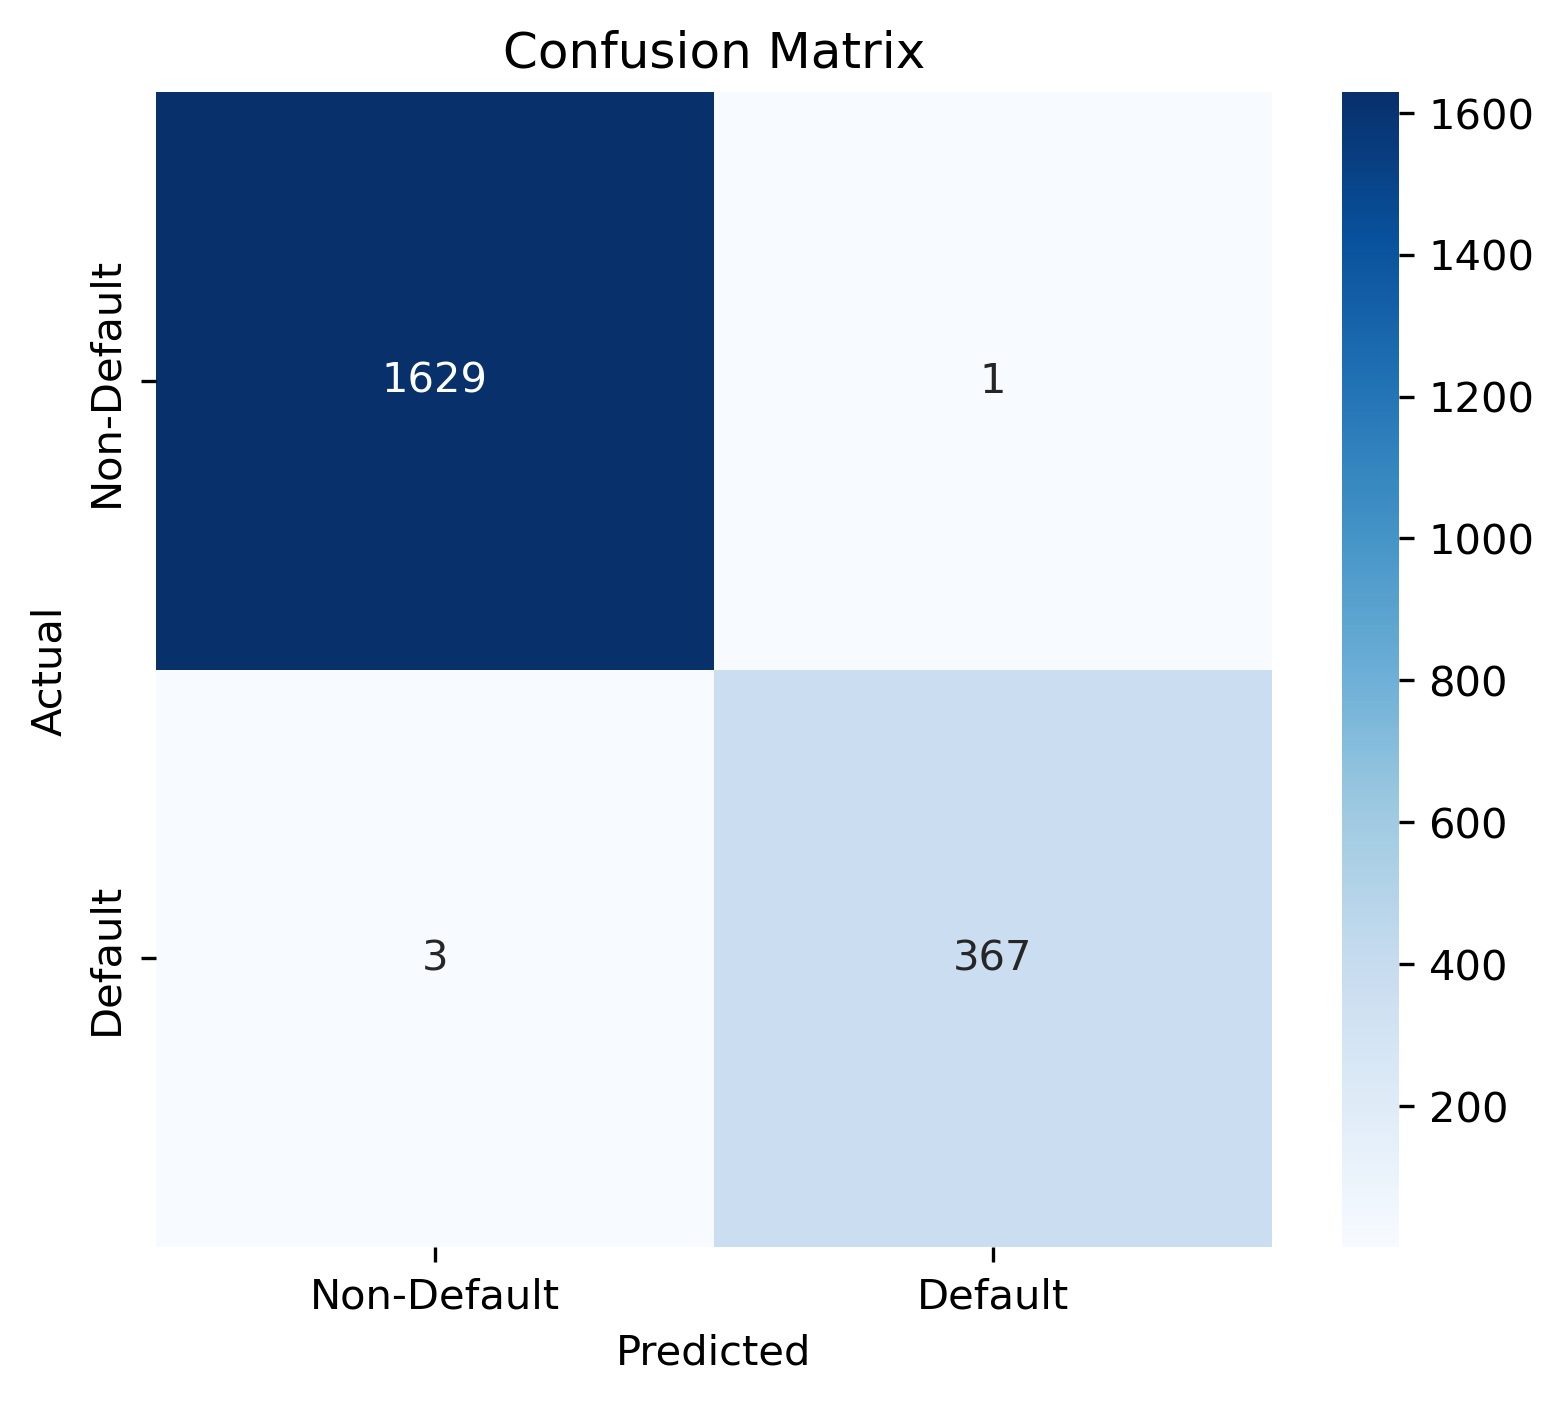

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Train the model
model_1 = LogisticRegression(random_state=42)
model_1.fit(X_train_scaled, y_train)

# Predict Predict probabilities on test set
y_proba = model_1.predict_proba(X_test_scaled)[:, 1]

# Predict class
y_pred = model_1.predict(X_test_scaled)

# Evaluate
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# # Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Interpretation of Results:
#### 1. Roc AUC Score: 0.999988
Almost perfect. This means the Logistic Regression model is almost perfectly distinguishing between defaulters and non-defaulters.
#### 2. Classification Report
- Accuracy: 1996 correct / 2000 total (~100%)
- Precision (Default=1): Of predicted defaulters, 100% were correct (1.00)
- Recall (Default=1): Caught 367 out of 370 actual defaulters (0.99)
- F1-score (Default=1): Balanced measure of precision + recall
#### 3. Confusion Matrix
- 1629 TN, 1 FP, 3 FN, 367 TP
- 1629 customers who did not default were correctly predicted as non-default (TN).
- 1 customer who did not default was incorrectly predicted as default (FP).
- 3 customers who did default were missed and predicted as non-default (FN).
- 367 customers who did default were correctly predicted (TP).

### Too good to be true? Possibly yes.
Unusual high scores usually mean that either:
- the data is too easy for the model to understand (i.e., `total_debt_outstanding`, `income`, `years_employed`, `fico_score`, etc. might directly correlate with default.
- or the dataset has some leakage (a feature that uninentionally "hinting" at the target).

## Expected Loss Analysis

Formula: `Expected Loss=PD×(1−Recovery Rate)×Loan Amount`
- PD: Probability of Default predicted by the model.
- Recovery Rate: 10% (assumed). Means 90% of loss if default happens.
- Loan Amount: `loan_amt_outstanding` feature.

In [114]:
print(y_proba[:10])

[1.57696713e-14 4.48674791e-05 1.20743101e-09 3.26347973e-11
 4.31948355e-11 7.31989139e-10 3.64849050e-09 9.99999946e-01
 2.62374346e-12 1.20207343e-10]


In [115]:
# Define recovery rate and LGD
recovery_rate = 0.10
lgd = 1 - recovery_rate  # Loss Given Default

# Loan amounts from unscaled test set
loan_amounts = X_test_original['loan_amt_outstanding'].values

# Compute Expected Loss for each customer
expected_loss = y_proba * lgd * loan_amounts

# Add to a new DataFrame for inspection
el_df = X_test_original.copy()
el_df['PD'] = y_proba
el_df['ExpectedLoss'] = expected_loss
el_df['ActualDefault'] = y_test.values

# Show the top 10 customers with the highest expected loss
highest_el = el_df.sort_values(by='ExpectedLoss', ascending=False)
highest_el.head(10)

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,debt_to_income,loan_to_income,PD,ExpectedLoss,ActualDefault
9944,4,8989.178801,30103.66256,124197.6337,2,641,0.242385,0.072378,0.999980,8090.096713,1
5460,5,8841.923630,32644.92158,115203.1519,2,541,0.283368,0.076751,1.000000,7957.731260,1
6364,4,8802.265206,26544.26350,108128.8413,2,534,0.245487,0.081405,0.999998,7922.023644,1
346,5,8638.366979,32789.35274,111631.4497,4,627,0.293729,0.077383,1.000000,7774.529481,1
7475,5,8427.592750,38215.41353,114303.6953,4,657,0.334332,0.073730,1.000000,7584.833424,1
2133,5,8276.572480,43688.78410,121048.3532,2,701,0.360920,0.068374,1.000000,7448.915232,1
5201,5,8055.214307,29424.29041,103156.2837,3,578,0.285240,0.078087,1.000000,7249.692770,1
7224,5,8042.192655,31775.12918,102824.6793,2,612,0.309022,0.078213,1.000000,7237.973384,1
7089,5,7989.706883,33434.40397,112065.0199,1,674,0.298348,0.071295,1.000000,7190.736189,1
8113,4,7987.436790,27860.93928,113825.2629,3,597,0.244769,0.070173,0.999951,7188.341040,1


### Key Observations

In [116]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_to_income,loan_to_income
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100,0.124018,0.059423
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398,0.082802,0.010642
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000,0.010000,0.012249
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000,0.068533,0.052125
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000,0.097434,0.059517
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000,0.163385,0.066717
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000,0.404561,0.102103


#### 1. The model is highly confident
- PD values are very close to 1, which suggests that the model is very certain these borrowers will default.
- In this top 10 list, every one of them actually did default (`ActualDefault = 1`).
#### 2. Expected Loss is well-aligned
- The formula is working correctly: customers with high loan amounts and high PDs result in large Expected Losses.
#### 3. Credit Quality and Risk Factors
- FICO scores are mostly low (534–674), indicating subprime or borderline prime borrowers.
- Debt-to-income ratios range from ~24% to 36%, on the higher side.
- Years employed is low (1–4), which could affect financial stability.

## Expected Loss Function
This is a function that can take in the properties of a loan and output the expected loss.

In [117]:
import numpy as np

def calculate_expected_loss(borrower_data, model, scaler, feature_columns, recovery_rate=0.10):
    """
    borrower_data: dict with keys matching original features (raw)
    model: trained model
    scaler: fitted scaler used during training
    feature_columns: list of columns used during model training (after feature engineering)
    recovery_rate: float, default 0.10
    """
    # Convert dict to DataFrame
    features = pd.DataFrame([borrower_data])
    
    # Feature engineering
    features['debt_to_income'] = features['total_debt_outstanding'] / features['income']
    features['loan_to_income'] = features['loan_amt_outstanding'] / features['income']

    # Reorder columns to match training
    features = features[feature_columns]

    # Scale
    scaled_features = scaler.transform(features)

    # Predict PD
    pd_default = model.predict_proba(scaled_features)[0][1]

    # Compute Expected Loss
    loan_amount = borrower_data['loan_amt_outstanding']
    expected_loss = pd_default * (1 - recovery_rate) * loan_amount

    return expected_loss

In [118]:
# Let's use the customer who has the highest Expected Loss (ID 9944)
sample = {
    'credit_lines_outstanding': 4,
    'loan_amt_outstanding': 8989.178801,
    'total_debt_outstanding': 30103.66256,
    'income': 124197.6337,
    'years_employed': 2,
    'fico_score': 641
}

el = calculate_expected_loss(sample, model_1, scaler, feature_columns)
print("Expected Loss:", el)

Expected Loss: 8090.096713201697


Perfect!

## XGBoost
Now let’s try training and evaluating a more advanced model (XGBoost), then compare it to the logistic regression model.

In [119]:
import xgboost as xgb

In [120]:
# Train XGBoost classifier
model_2 = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model_2.fit(X_train, y_train)

# Predict probabilities and classes
y_proba_xgb = model_2.predict_proba(X_test)[:, 1]
y_pred_xgb = model_2.predict(X_test)

ROC AUC Score: 0.9999618637041949

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       1.00      0.98      0.99       370

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



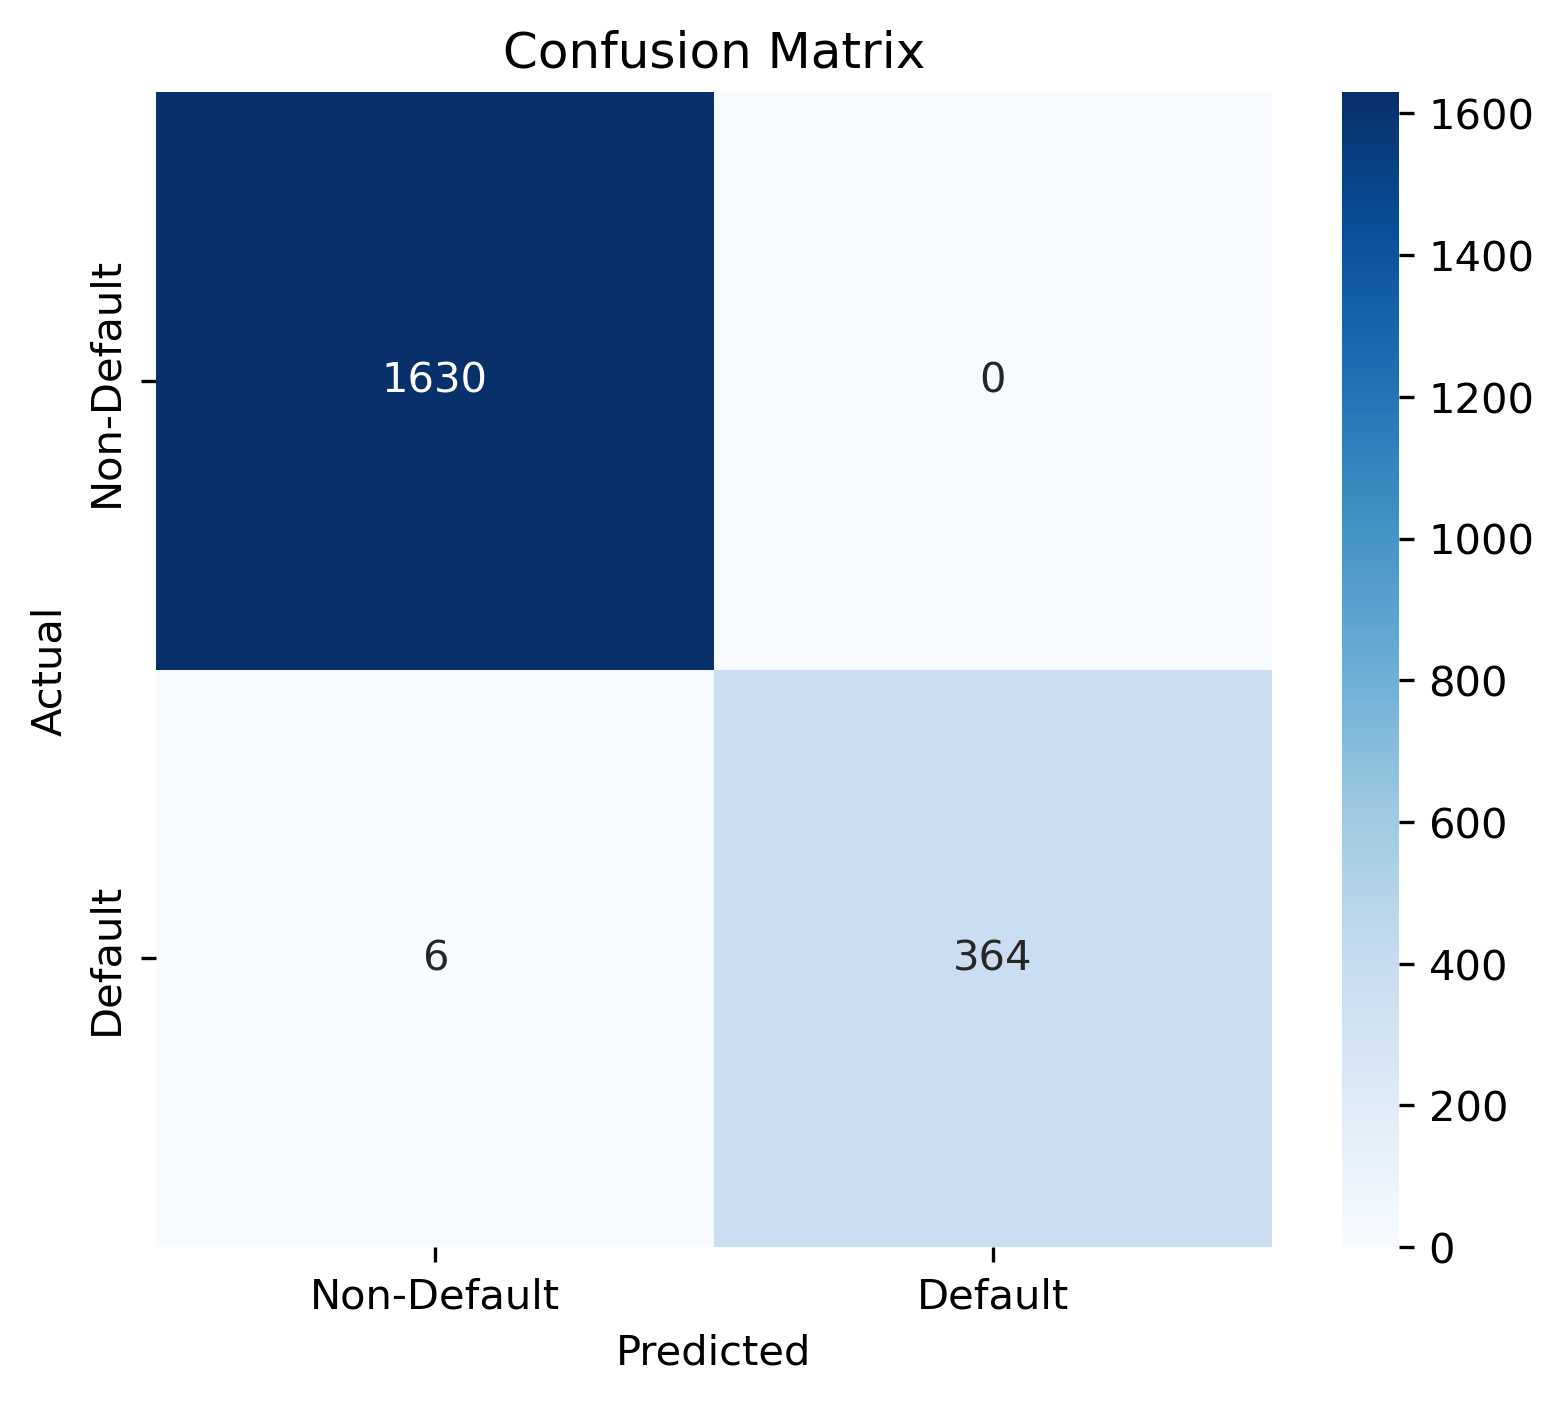

In [122]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Recap

- 1630 TN, 0 FP, 6 FN, 364 TP
- 1630 non-defaults correctly predicted (TN). Perfect.
- 0 false alarms (FP). Perfect again!
- 364 defaults correctly predicted (TP). Slightly less than the logistic regression.
- 6 defaults missed (FN). More than the logistic regression.

Both models (Logistic Regression and XGBoost) performed exceptionally well. Near perfect for this dataset. But, since false negative (FN) is often more costly than false positive (FP) in banking, **logistic regression might be preferable for this kind of task**.

A **false negative** occurs when the model predicts a borrower will not default, but the borrower actually does default. This is highly problematic because it results in the bank approving a loan to a high-risk customer, which leads to significant financial loss if the borrower is unable to repay. For example, with a loan of 100,000 dollars and a recovery rate of only 10%, the bank may lose up to 90,000 dollars from a single FN.

On the other hand, a **false positive** means predicting that a borrower will default when, in fact, they would have repaid the loan. While this leads to missed opportunities and lost potential revenue, it does not result in direct financial loss.